# Pixmo Dataset Advanced EDA

This notebook performs comprehensive Exploratory Data Analysis (EDA) on the Pixmo datasets.
It covers two datasets provided:
1. **Pixmo Dataset** (`dataset/final_dataset/pixmo`): Likely Image-Text pairs.
2. **Pixmo QA Mixed** (`dataset/final_dataset/pixmo_alignment`): Likely Question-Answer pairs.

The analysis includes:
- **Data Distribution**: Split sizes (Train/Val/Test).
- **Text Analysis**: 
    - Length statistics (char/word counts).
    - Vocabulary (Word Clouds).
    - **New**: N-gram analysis (Bigrams).
    - **New**: Question Type distribution (for QA).
- **Image Analysis**:
    - **New**: Aspect Ratio & Size visualization.
    - **New**: Image + Long Caption samples.
- **Outputs**: All plots saved to `/home/hice1/vchopra37/scratch/projects/edge_glass/images` for publication.

In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io
from wordcloud import WordCloud
from collections import Counter
import textwrap
from sklearn.feature_extraction.text import CountVectorizer

# Set style for plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Ensure output directory exists
OUTPUT_DIR = "/home/hice1/vchopra37/scratch/projects/edge_glass/images"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [25]:
# Dataset Paths
PIXMO_DIR = "/home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo"
PIXMO_QA_DIR = "/home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo_alignment"

PIXMO_FILES = {
    "train": os.path.join(PIXMO_DIR, "pixmo_train.parquet"),
    "val": os.path.join(PIXMO_DIR, "pixmo_val.parquet"),
    "test": os.path.join(PIXMO_DIR, "pixmo_test.parquet")
}

PIXMO_QA_FILES = {
    "train": os.path.join(PIXMO_QA_DIR, "pixmo_qa_mixed_train.parquet"),
    "val": os.path.join(PIXMO_QA_DIR, "pixmo_qa_mixed_val.parquet"),
    "test": os.path.join(PIXMO_QA_DIR, "pixmo_qa_mixed_test.parquet")
}

In [26]:
def load_dataset(files_dict, name="Dataset"):
    data = {}
    print(f"Loading {name}...")
    for split, path in files_dict.items():
        if os.path.exists(path):
            try:
                df = pd.read_parquet(path)
                data[split] = df
                print(f"  {split}: {len(df)} samples")
            except Exception as e:
                print(f"  Error loading {split}: {e}")
        else:
            print(f"  {split} file not found at {path}")
    return data

## 1. Load Data

In [27]:
pixmo_data = load_dataset(PIXMO_FILES, "Pixmo")
pixmo_qa_data = load_dataset(PIXMO_QA_FILES, "Pixmo QA Mixed")

Loading Pixmo...
  train: 14000 samples
  val: 3000 samples
  test: 3000 samples
Loading Pixmo QA Mixed...
  train: 8400 samples
  val: 1800 samples
  test: 1800 samples


## 2. General Statistics

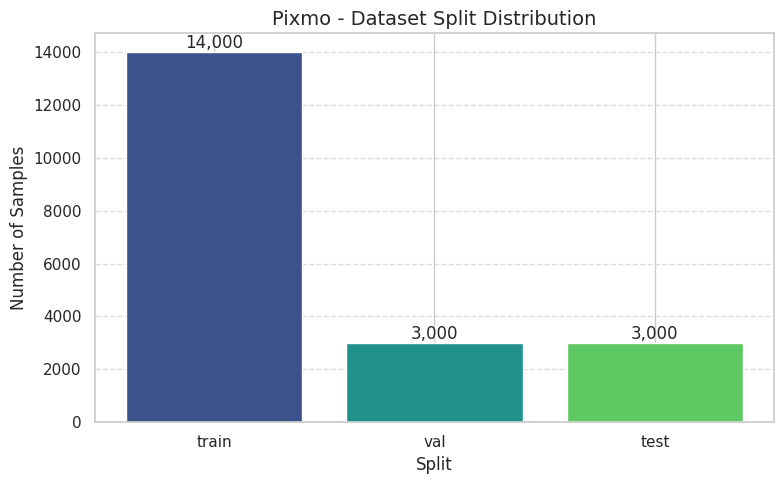

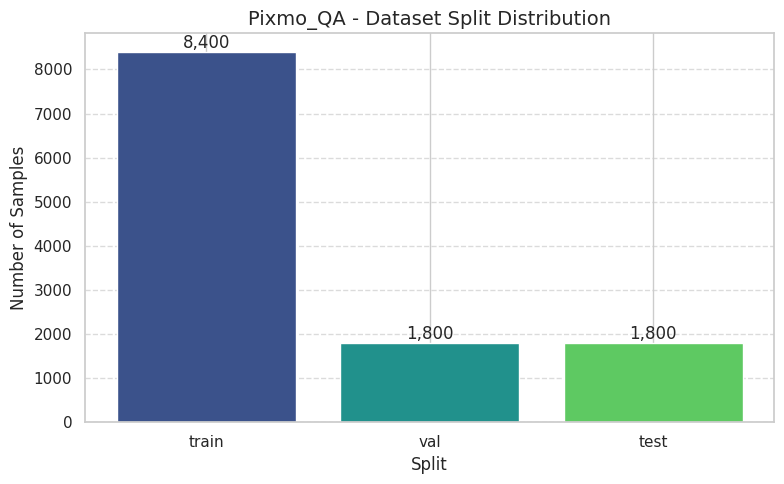

In [28]:
def plot_split_distribution(data_dict, title_prefix):
    splits = list(data_dict.keys())
    counts = [len(df) for df in data_dict.values()]
    colors = sns.color_palette("viridis", len(splits))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(splits, counts, color=colors)
    plt.title(f"{title_prefix} - Dataset Split Distribution", fontsize=14)
    plt.ylabel("Number of Samples")
    plt.xlabel("Split")
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height):,}', ha='center', va='bottom', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{title_prefix.lower().replace(' ', '_')}_splits.png"), dpi=300)
    plt.show()

plot_split_distribution(pixmo_data, "Pixmo")
plot_split_distribution(pixmo_qa_data, "Pixmo_QA")

## 3. Text Analysis

In [29]:
# Identify text columns dynamically
PIXMO_TEXT_COL = 'caption' if 'caption' in pixmo_data['train'].columns else 'text'
# For QA, we typically have 'question' and 'answer' or 'conversations'
# Based on typical formats, checking for 'question' first
if 'question' in pixmo_qa_data['train'].columns:
    QA_Q_COL = 'question'
    QA_A_COL = 'answer'
else:
    # Fallback or need to inspect (user saw 'conversations' earlier?)
    # User output showed: ['image_url', 'image_sha256', 'image_bytes', 'question', 'answer', 'source']
    QA_Q_COL = 'question'
    QA_A_COL = 'answer'

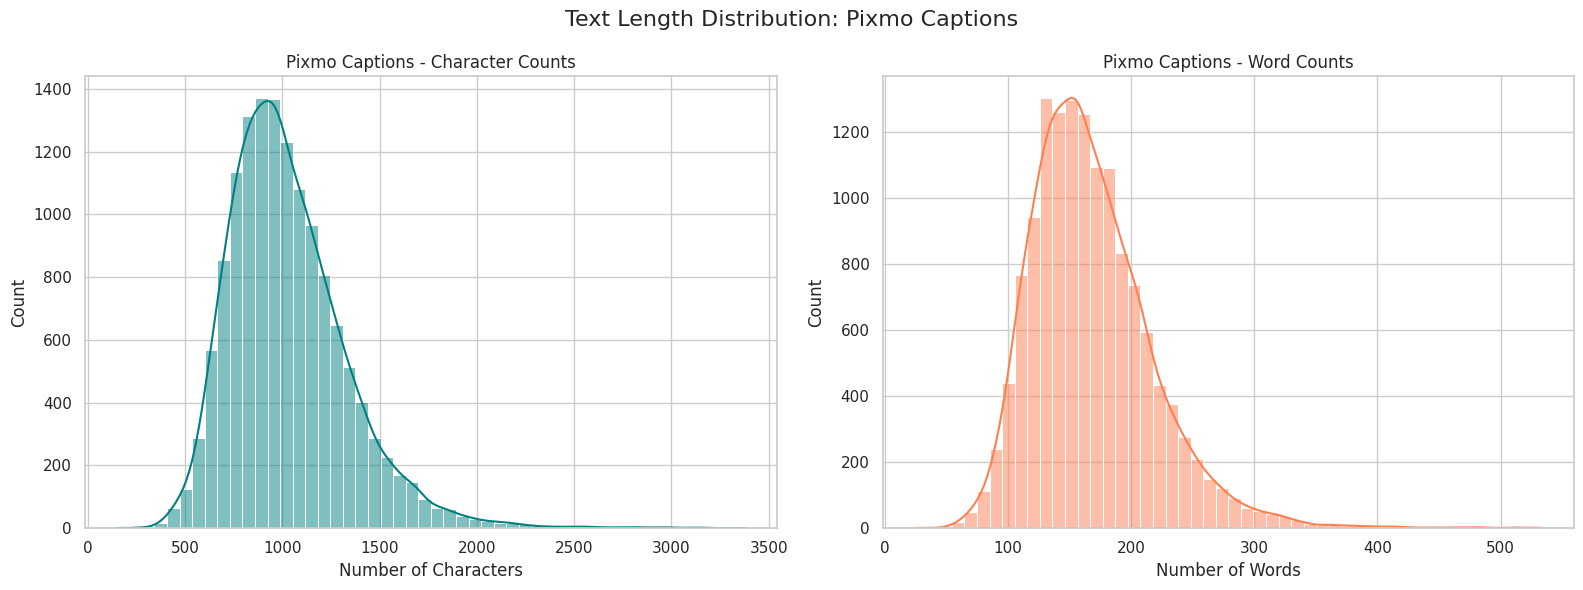

Pixmo Captions Stats:
  Mean Words: 168.06
  Max Words: 534


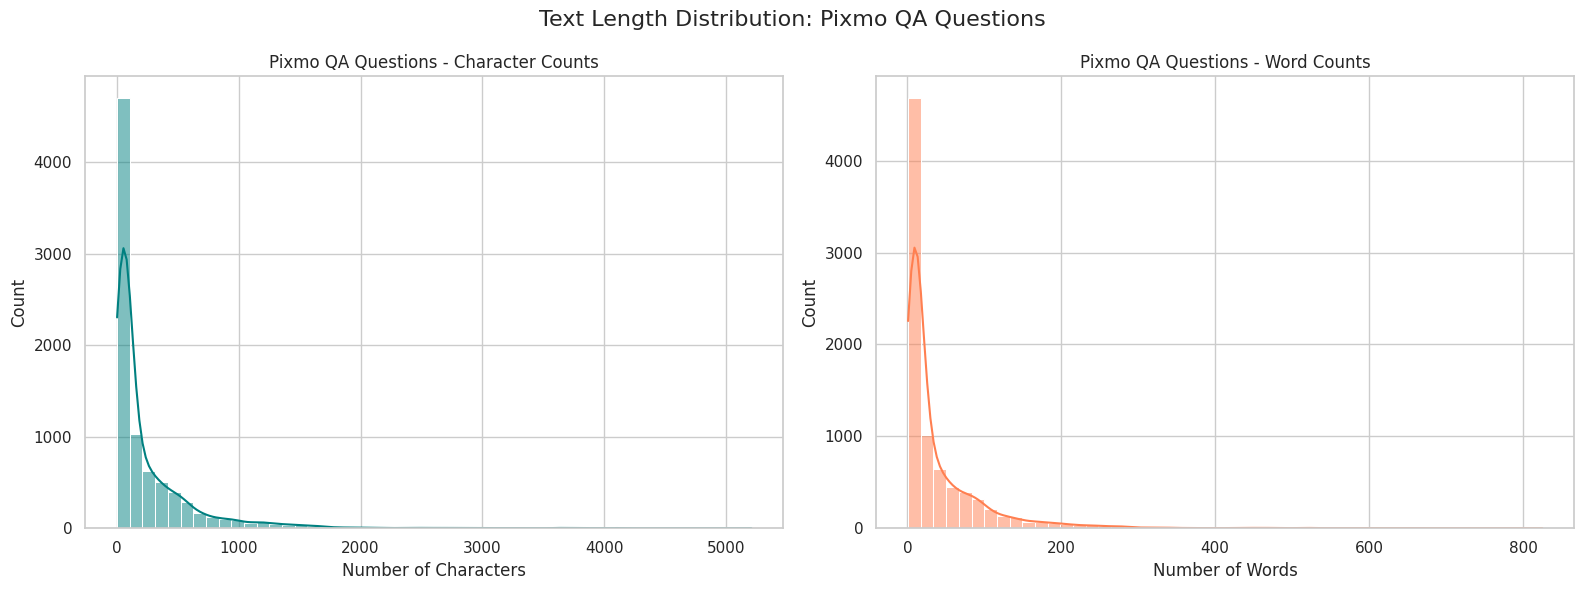

Pixmo QA Questions Stats:
  Mean Words: 40.34
  Max Words: 825


In [30]:
def analyze_text_lengths(df, col, title):
    texts = df[col].dropna().astype(str).tolist()
    char_lens = [len(t) for t in texts]
    word_lens = [len(t.split()) for t in texts]
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Character Count
    sns.histplot(char_lens, bins=50, kde=True, ax=ax[0], color='teal')
    ax[0].set_title(f"{title} - Character Counts")
    ax[0].set_xlabel("Number of Characters")
    
    # Word Count
    sns.histplot(word_lens, bins=50, kde=True, ax=ax[1], color='coral')
    ax[1].set_title(f"{title} - Word Counts")
    ax[1].set_xlabel("Number of Words")
    
    plt.suptitle(f"Text Length Distribution: {title}", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{title.lower().replace(' ', '_')}_lengths.png"), dpi=300)
    plt.show()
    
    print(f"{title} Stats:")
    print(f"  Mean Words: {np.mean(word_lens):.2f}")
    print(f"  Max Words: {np.max(word_lens)}")

analyze_text_lengths(pixmo_data['train'], PIXMO_TEXT_COL, "Pixmo Captions")
analyze_text_lengths(pixmo_qa_data['train'], QA_Q_COL, "Pixmo QA Questions")

/home/hice1/vchopra37/scratch/models/tmp/ipykernel_1598734/3654905845.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="rocket")


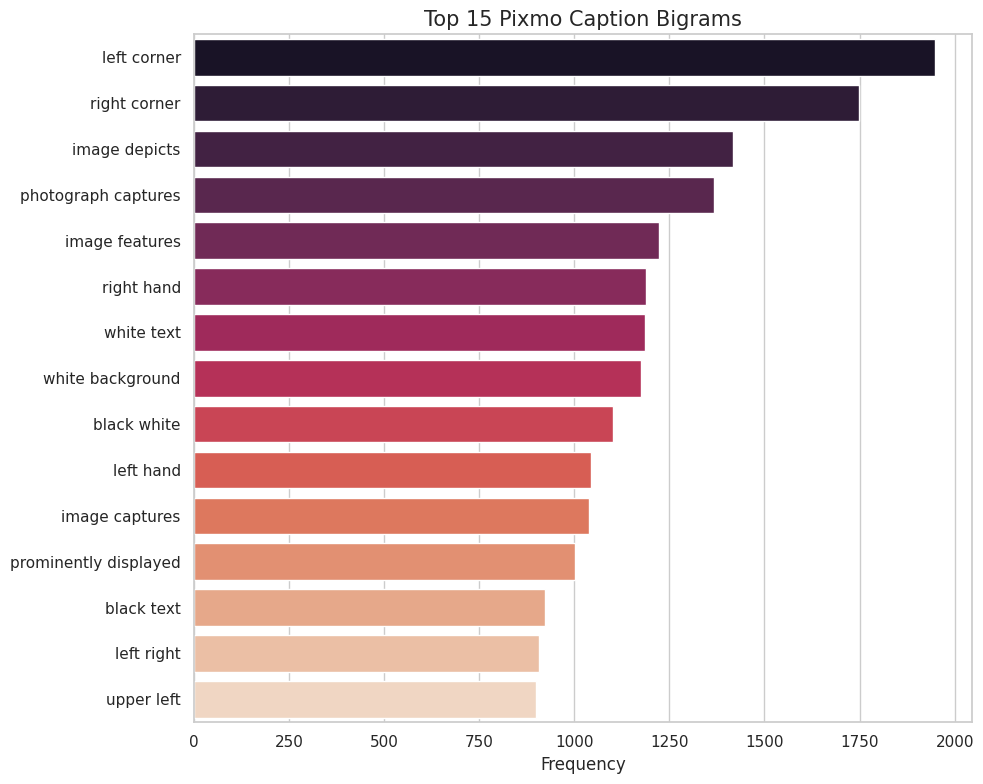

In [31]:
def plot_ngrams(df, col, n=2, title="Bigrams", top_k=15):
    texts = df[col].dropna().astype(str).tolist()
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:top_k]
    
    words, freqs = zip(*words_freq)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=list(freqs), y=list(words), palette="rocket")
    plt.title(f"Top {top_k} {title}", fontsize=15)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{title.lower().replace(' ', '_')}_ngrams.png"), dpi=300)
    plt.show()

plot_ngrams(pixmo_data['train'], PIXMO_TEXT_COL, n=2, title="Pixmo Caption Bigrams")

/home/hice1/vchopra37/scratch/models/tmp/ipykernel_1598734/4179059082.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_starters.keys()), y=list(top_starters.values()), palette="mako")


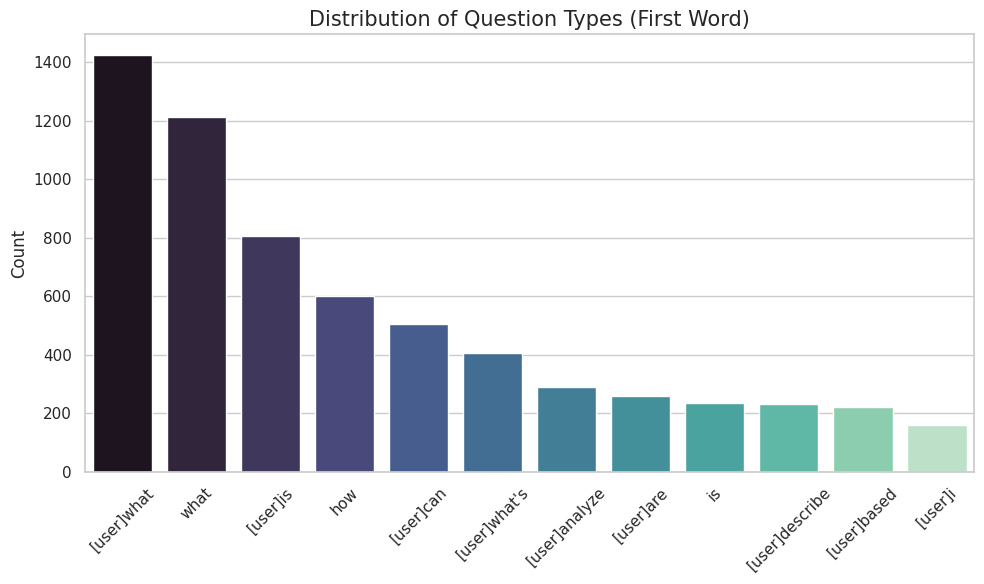

In [32]:
def analyze_question_types(df, col="question"):
    questions = df[col].dropna().astype(str).tolist()
    # Get first word (lowercase)
    starters = [q.split()[0].lower().strip('"\'¿') for q in questions if len(q.split()) > 0]
    
    counts = Counter(starters)
    top_starters = dict(counts.most_common(12))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(top_starters.keys()), y=list(top_starters.values()), palette="mako")
    plt.title("Distribution of Question Types (First Word)", fontsize=15)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "qa_question_types.png"), dpi=300)
    plt.show()

analyze_question_types(pixmo_qa_data['train'], QA_Q_COL)

## 4. Image Analysis (Advanced)

In [33]:
# Function to safely decode images
def decode_image_bytes(image_data):
    if isinstance(image_data, bytes):
        return Image.open(io.BytesIO(image_data))
    elif isinstance(image_data, dict) and 'bytes' in image_data:
        return Image.open(io.BytesIO(image_data['bytes']))
    return None

Analyzing 1000 images for Pixmo...


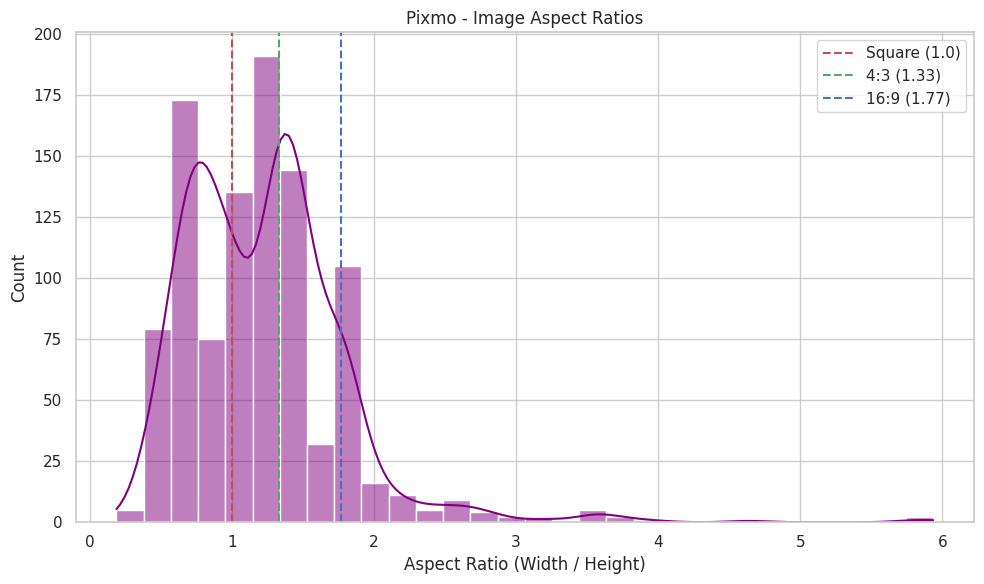

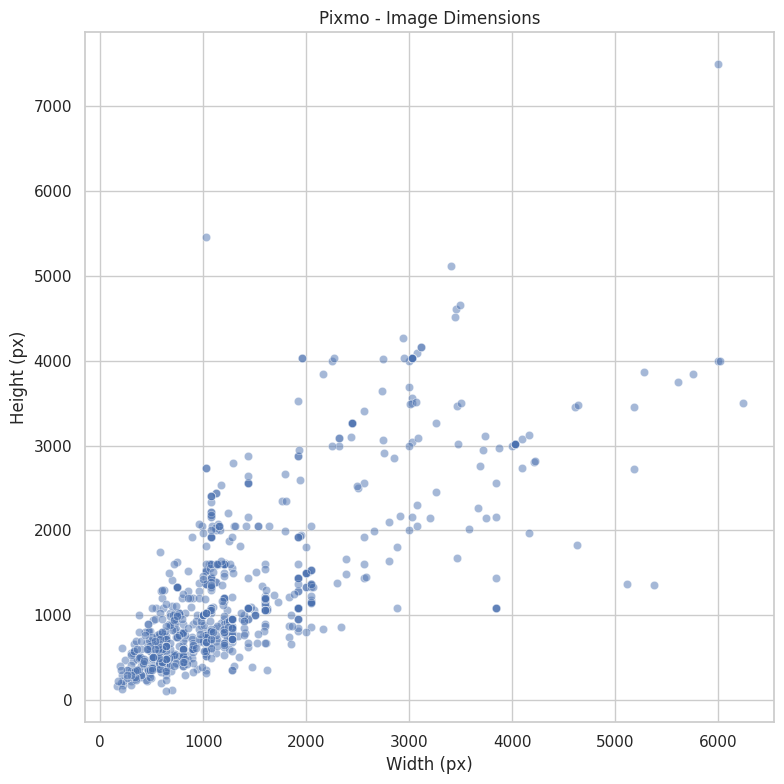

In [34]:
def analyze_aspect_ratios(df, image_col='image_bytes', sample_size=1000, title="Dataset"):
    widths = []
    heights = []
    ratios = []
    
    sample_df = df.dropna(subset=[image_col])
    if len(sample_df) > sample_size:
        sample_df = sample_df.sample(sample_size, random_state=42)
    
    print(f"Analyzing {len(sample_df)} images for {title}...")
    
    for _, row in sample_df.iterrows():
        try:
            img = decode_image_bytes(row[image_col])
            if img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
                ratios.append(w/h)
        except:
            continue
            
    # Plot 1: Aspect Ratio Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(ratios, bins=30, kde=True, color='purple')
    plt.axvline(x=1.0, color='r', linestyle='--', label='Square (1.0)')
    plt.axvline(x=1.33, color='g', linestyle='--', label='4:3 (1.33)')
    plt.axvline(x=1.77, color='b', linestyle='--', label='16:9 (1.77)')
    plt.title(f"{title} - Image Aspect Ratios")
    plt.xlabel("Aspect Ratio (Width / Height)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{title.lower().replace(' ', '_')}_ar.png"), dpi=300)
    plt.show()
    
    # Plot 2: Width vs Height Scatter
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=widths, y=heights, alpha=0.5)
    plt.title(f"{title} - Image Dimensions")
    plt.xlabel("Width (px)")
    plt.ylabel("Height (px)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{title.lower().replace(' ', '_')}_dims.png"), dpi=300)
    plt.show()

analyze_aspect_ratios(pixmo_data['train'], 'image_bytes', title="Pixmo")

## 5. Visualizations: Image + Caption (Long Text Handling)

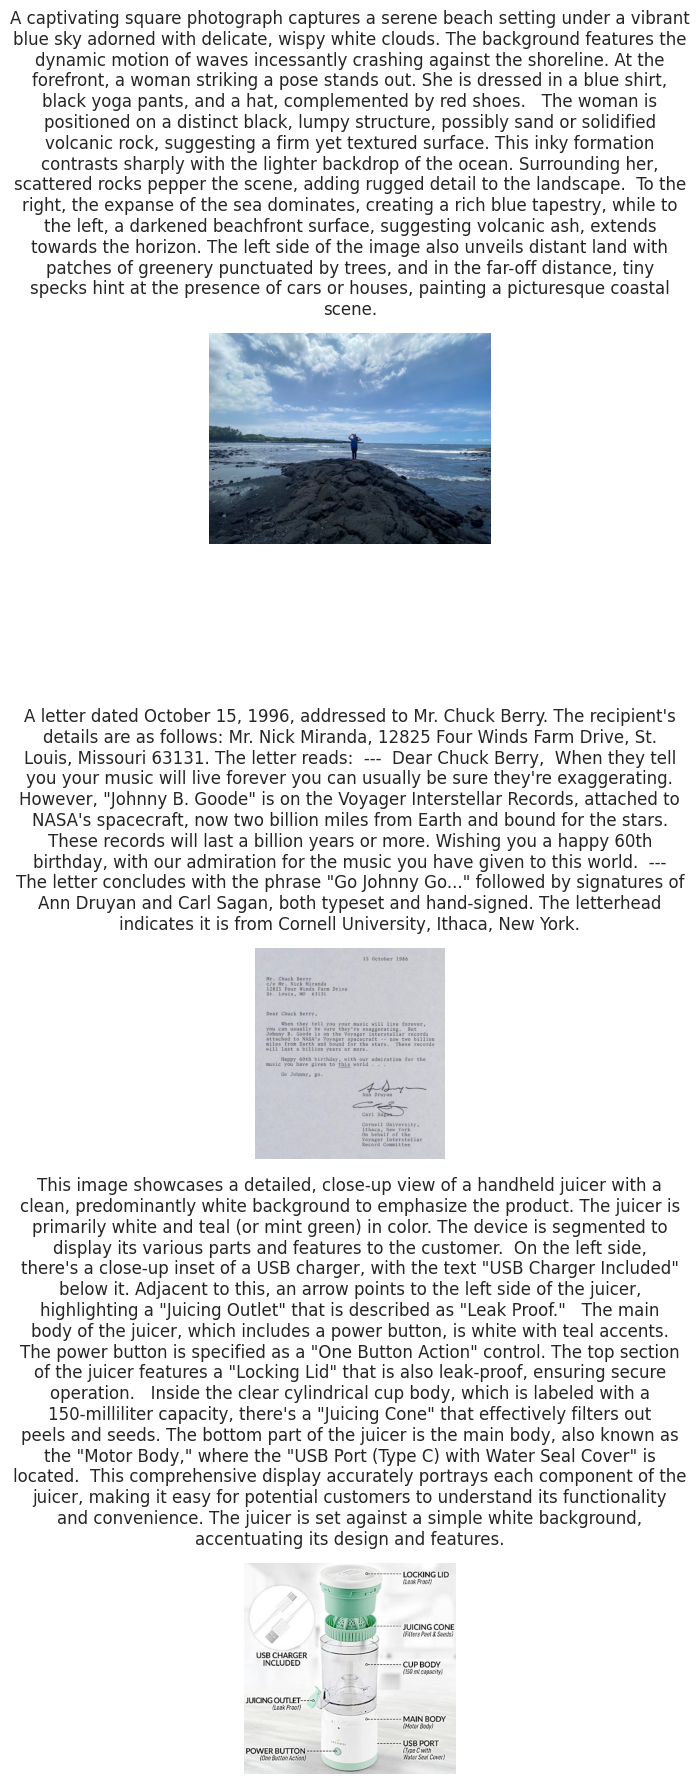

In [35]:
def visualize_samples_with_long_captions(df, image_col, text_col, num_samples=3):
    """
    Visualizes images with potentially long captions by displaying them side-by-side
    or properly wrapped below. This version puts caption BELOW image with wrapping.
    """
    sample_df = df.sample(num_samples, random_state=42)
    
    # Create a figure with subplots (1 column, N rows)
    # Adjust height based on samples
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 6 * num_samples))
    if num_samples == 1:
        axes = [axes]
    
    for i, (_, row) in enumerate(sample_df.iterrows()):
        ax = axes[i]
        
        # Decode image
        try:
            img = decode_image_bytes(row[image_col])
            if img:
                # Resize for display consistency if needed, keeping aspect ratio
                img.thumbnail((800, 800))
                ax.imshow(img)
            else:
                ax.text(0.5, 0.5, "[Image Data Missing]", ha='center')
        except Exception as e:
            ax.text(0.5, 0.5, f"[Error Decoding: {e}]", ha='center')
            
        ax.axis('off')
        
        # Handle Text Wrapping
        caption = str(row[text_col])
        # Wrap text to ~80 chars width
        wrapped_text = "\n".join(textwrap.wrap(caption, width=80))
        
        ax.set_title(wrapped_text, fontsize=12, pad=15, loc='center', wrap=True)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "samples_long_captions.png"), dpi=300)
    plt.show()

# Run visualization for Pixmo (Captions)
visualize_samples_with_long_captions(pixmo_data['train'], 'image_bytes', PIXMO_TEXT_COL, num_samples=3)

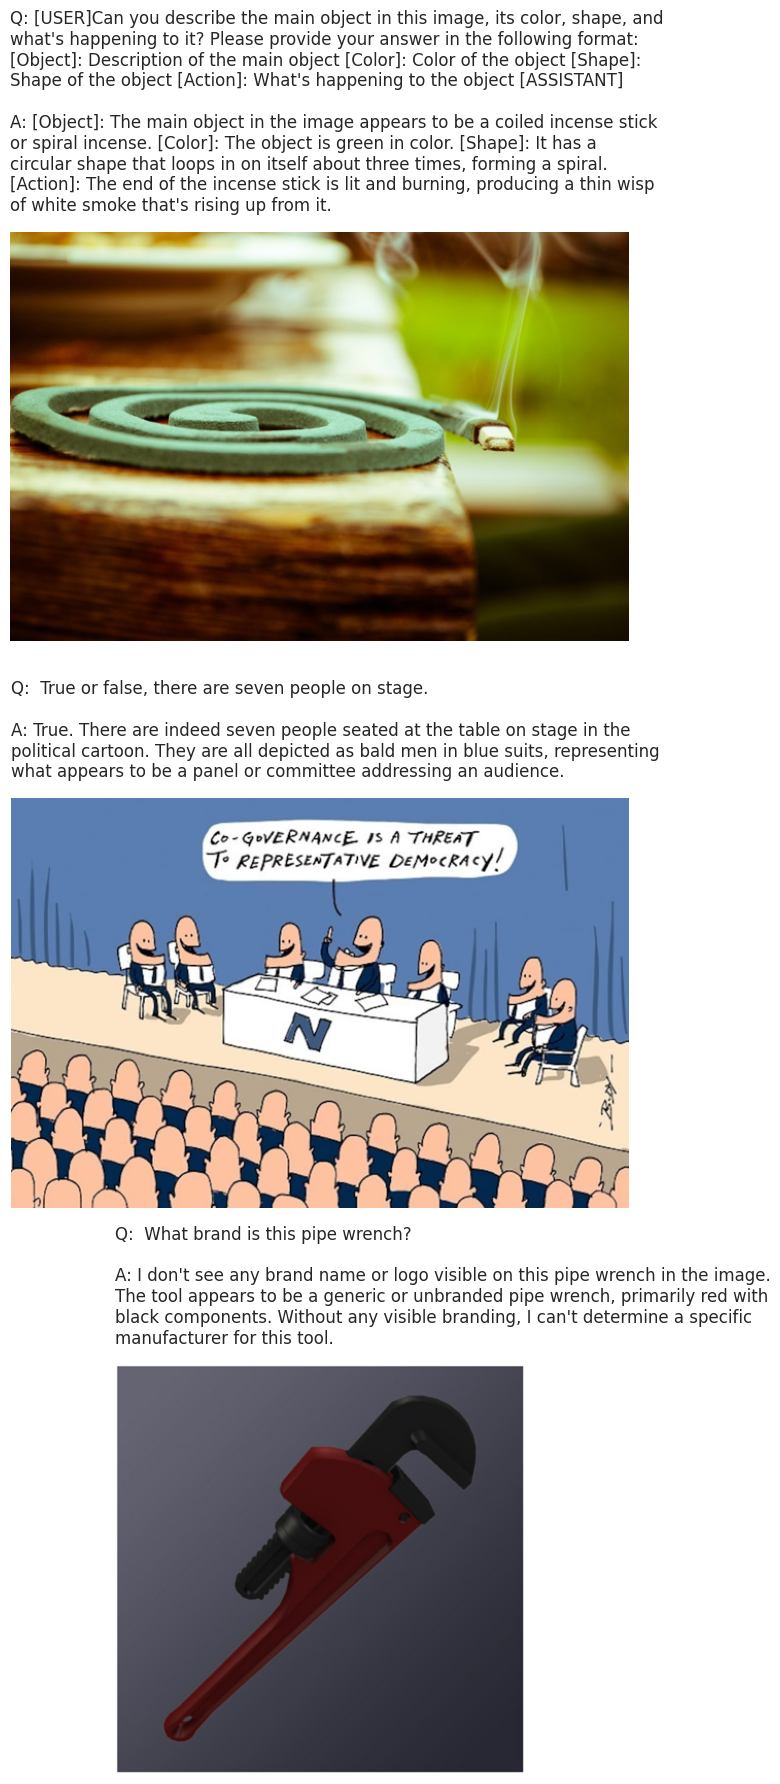

In [36]:
# Run visualization for Pixmo QA (Questions + Answers)
def visualize_qa_samples(df, image_col, q_col, a_col, num_samples=3):
    sample_df = df.sample(num_samples, random_state=99)
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 6 * num_samples))
    if num_samples == 1:
        axes = [axes]
        
    for i, (_, row) in enumerate(sample_df.iterrows()):
        ax = axes[i]
        try:
            img = decode_image_bytes(row[image_col])
            if img:
                img.thumbnail((600, 600))
                ax.imshow(img)
        except:
            pass
        ax.axis('off')
        
        q_text = textwrap.fill(f"Q: {row[q_col]}", width=80)
        a_text = textwrap.fill(f"A: {row[a_col]}", width=80)
        
        ax.set_title(f"{q_text}\n\n{a_text}", fontsize=12, pad=15, loc='left')
        
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "samples_qa.png"), dpi=300)
    plt.show()

if 'train' in pixmo_qa_data:
    visualize_qa_samples(pixmo_qa_data['train'], 'image_bytes', QA_Q_COL, QA_A_COL, num_samples=3)